<a href="https://colab.research.google.com/github/Tahahaha7/Capstone_Project/blob/master/Capstone_Modeling_M1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!apt install libspatialindex-dev
!pip install rtree
!pip install momepy
!pip install osmapi
!pip install pygeos

In [ ]:
%%capture
!pip install -Iv osmnx==0.16.0

In [ ]:
%%capture
!pip install geopandas
!pip install humanfriendly
!pip install mplleaflet

In [ ]:
%%capture
!pip install pandas==1.1.3

In [ ]:
# Importing packages

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import operator
import rtree
import osmnx as ox
import geopandas as gpd
import momepy

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
ox.config(use_cache=True, log_console=True)
weight = 'length'

ox.__version__, pd.__version__

# $\text{Compiling all the data}$

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/Capstone

/content/gdrive/My Drive/Capstone


## $\text{Road Network}$

In [ ]:
# Exrtact the entire road network of the city

%%time
road_network = ox.graph_from_place('London, UK', network_type='drive')

In [ ]:
fig, ax = ox.plot_graph(road_network, node_size=1, edge_color='w', edge_linewidth=0.2, figsize=(25, 15))

In [ ]:
from shapely import wkt

#final_osm_nodes = gpd.read_file('final_osm_nodes.gpkg', driver='GPKG')
final_osm_nodes = pd.read_csv('final_osm_nodes.csv')
final_osm_nodes['geometry'] = final_osm_nodes['geometry'].apply(wkt.loads)

In [ ]:
final_osm_nodes.columns

Index(['y', 'x', 'osmid', 'geometry', 'station', 'station_name', 'imd',
       'population', 'children', 'elderly', 'men', 'women', 'women_15_49',
       'youth'],
      dtype='object')

In [ ]:
final_osm_nodes.head()

,y,x,osmid,geometry,station,station_name,imd,population,children,elderly,men,women,women_15_49,youth
0,51.526976,-0.145792,78112,POINT (-0.1457924 51.526976),False,NaN,20.339,5.91539,0.18449,1.77573,2.74432,2.90574,1.31450,0.50735
1,51.523611,-0.152791,99936,POINT (-0.1527906 51.5236106),False,NaN,20.339,9.98400,0.55808,2.87626,4.33585,4.80807,2.06060,0.77273
2,51.523018,-0.152023,99937,POINT (-0.1520235 51.5230177),False,NaN,20.339,8.20282,0.61328,0.80492,4.13961,3.37301,2.41477,0.84325
3,51.535179,-0.148104,101818,POINT (-0.1481038 51.5351787),False,NaN,20.131,5.86710,0.25944,1.78150,2.73278,2.87115,1.00317,0.43240
4,51.535612,-0.147044,101831,POINT (-0.1470438 51.5356116),False,NaN,20.131,5.86710,0.25944,1.78150,2.73278,2.87115,1.00317,0.43240


In [ ]:
# Add the nodes for hospitals
from ast import literal_eval
from shapely.ops import nearest_points
from shapely.geometry import Point, MultiPoint

london_hospitals = pd.read_csv('london_hospitals.csv')
london_hospitals.location  = [literal_eval(london_hospitals.location[i]) for i in range(len(london_hospitals))]
london_hospitals.location = [Point(x,y) for [x,y] in london_hospitals.location]

In [ ]:
near = [nearest_points(hospital, MultiPoint(final_osm_nodes.geometry))[1] for hospital in london_hospitals.location]

In [ ]:
final_osm_nodes['hospital'] = [True if node in near else False for node in final_osm_nodes.geometry]

In [ ]:
hospital_name = [np.nan]*len(final_osm_nodes); count = 0
for idx, i in enumerate(final_osm_nodes.hospital):
    if i: 
        hospital_name[idx] = london_hospitals['name'][count]
        count+=1

final_osm_nodes['hospital_name'] = hospital_name
final_osm_nodes['hospital_name'].value_counts()

Royal London Hospital for Integrated Medicine    1
St Thomas' Hospital                              1
London Bridge Hospital                           1
The Princess Grace Hospital                      1
King Edward VII's Hospital                       1
The Royal London Hospital                        1
University College Hospital                      1
Name: hospital_name, dtype: int64

In [ ]:
#uber_osm = gpd.read_file("uber_osm.gpkg", driver="GPKG")
uber_osm = pd.read_csv('uber_osm.csv')

In [ ]:
uber_osm['speed_mean_mps'] = uber_osm['speed_mean_mph'].fillna(uber_osm['maxspeed'].astype(int)).values * 0.44704 # from mph to m/s
uber_osm['mean_travel_time'] = uber_osm.length.values / uber_osm.speed_mean_mps.values

In [ ]:
uber_osm.isna().sum()

In [ ]:
plt.hist(uber_osm['speed_mean_mps'], bins='auto');

In [ ]:
final_osm_nodes.hospital.value_counts()

False    126761
True          7
Name: hospital, dtype: int64

In [ ]:
Graph = nx.from_pandas_edgelist(uber_osm,
                                source='osmid_source', 
                                target='osmid_target', 
                                create_using=nx.MultiDiGraph(), 
                                edge_attr=['name', 'length', 'maxspeed', 'speed_mean_mph',
                                           'pct_from_freeflow', 'speed_freeflow_mph',
                                           'mean_travel_time', 'speed_mean_mps', 
                                           'geometry'])

print(nx.info(Graph))

Name: 
Type: MultiDiGraph
Number of nodes: 126768
Number of edges: 297638
Average in degree:   2.3479
Average out degree:   2.3479


In [ ]:
nx.is_weakly_connected(Graph)

True

In [ ]:
dict_osm = {x: {'position': (a, b), 'imd': c, 
                'station': (d, dd), 'hospital': (m, mm),
                'population':e, 'children':f, 'elderly':g,
                'men':h, 'women':i, 'women_15_49':j, 'youth':k}
            for x, a, b, c, d, dd, m, mm, e, f, g, h, i, j, k in zip(final_osm_nodes.osmid, final_osm_nodes.x, 
                                                                     final_osm_nodes.y, final_osm_nodes.imd, 
                                                                     final_osm_nodes.station, final_osm_nodes.station_name,
                                                                     final_osm_nodes.hospital, final_osm_nodes.hospital_name,
                                                          final_osm_nodes.population, 
                                                          final_osm_nodes.children, final_osm_nodes.elderly, 
                                                          final_osm_nodes.men, final_osm_nodes.women, 
                                                          final_osm_nodes.women_15_49, final_osm_nodes.youth)}

nx.set_node_attributes(Graph, dict_osm)

In [ ]:
#list(Graph.edges(data=True))[0]
list(Graph.nodes(data=True))[0]

(78112,
 {'children': 0.18449,
  'elderly': 1.77573,
  'hospital': (False, nan),
  'imd': 20.339000000000002,
  'men': 2.74432,
  'population': 5.91539,
  'position': (-0.1457924, 51.526976),
  'station': (False, nan),
  'women': 2.90574,
  'women_15_49': 1.3145,
  'youth': 0.50735})

In [ ]:
# Relabeling nodes just to draw
'''
Graph_copy = Graph.copy()
Graph_copy = nx.relabel_nodes(Graph_copy, dict(zip(Graph_copy.nodes, range(len(Graph_copy.nodes)))))

plt.figure(figsize=(25, 15))
nx.draw(Graph_copy, pos = [Graph_copy.nodes[i]['position'] for i in Graph_copy.nodes],
        node_size=10, node_color = 'blue', with_labels=False)
plt.show()''';

# $\text{Fixed Ambulance Stations}$

In [ ]:
# Faster runs

#list(np.random.choice(list(Graph_copy.nodes), p=normalized_population, size=100))
def find(s, t):
  try: nx.dijkstra_path(Graph_copy, s, t, weight='mean_travel_time')
  except: return 1

find(0, 115598)
#edge_list = list(map(tuple, zip(edge_list, edge_list[1:])))

#trv_cost = 0
#for i in edge_list: trv_cost+=Graph_copy.get_edge_data(i[0], i[1])[0]['mean_travel_time']

1

In [ ]:
Graph_copy = Graph.copy()
Graph_copy = nx.relabel_nodes(Graph_copy, dict(zip(Graph_copy.nodes, range(len(Graph_copy.nodes)))))

In [ ]:
%timeit path = nx.shortest_path(Graph_copy, 0, 500, weight='mean_travel_time')

10 loops, best of 5: 45.1 ms per loop


In [ ]:
%load_ext Cython

In [ ]:
%%cython

import numpy as np
import pandas as pd
import networkx as nx

class simulation:
        
    def initialize(self, graph, n_requests): #, v_ambulance):
        
        self.graph = graph # Graph of the city

        #self.v_ambulance = v_ambulance # measured in m/s

        self.station_nodes = [node[0] for node in self.graph.nodes(data=True) if node[1]['station'][0]]

        self.hospital_nodes = [node[0] for node in self.graph.nodes(data=True) if node[1]['hospital'][0]]
        
        self.n_requests = n_requests # The number of requests
        
        self.station_visits = [] # Record the station from which ambulance dispatched
        self.hospital_visits = [] # Record the hospital to which ambulance directed back to

        self.requests = [] # Record the nodes that generated ambulance calls
        
    def generate_requests(self):
        '''
        The function generates emergency calls in different regions of the city
        using a random sampler weighted by the normalized criminality rate.
        (i.e., a region with relatively high criminality rate would have more
        frequent ambulance calls)
        '''
        # Put all crime rates of regions into a list
        #crime_rates = list(nx.get_node_attributes(self.graph,'crime_rate').values())

        population = list(nx.get_node_attributes(self.graph,'population').values())
        
        #category_counts = [12441, 60485, 19972, 1610] # from historical data

        # Normalize all the crime rate to serve as a probability distribution
        #normalized_population = [float(i)/sum(population) for i in population]

        normalized_population = population / np.sum(population) #population / np.linalg.norm(population)
        
        #normalized_category_counts = category_counts / np.sum(category_counts)
        # Create n_requests for ambulance in different regions of the city
        #for i in range(self.n_requests):
            #self.requests.append(np.random.choice(list(self.graph.nodes), p=normalized_population))
        
        '''
        if self.priority: self.requests = list(zip(np.random.choice(list(range(1, 5)), p=normalized_category_counts, size=self.n_requests),
                                                   np.random.choice(list(self.graph.nodes), p=normalized_population, size=self.n_requests)))
        '''
        self.requests = list(np.random.choice(list(self.graph.nodes), p=normalized_population, size=self.n_requests))
            
        
    def estimated_travel_time(self, edge_list):
        '''
        The function estimates the average travel time thru the shortest path between 
        the hospital and the region from which the emergency call was generated.
        
        - Methodology:
        For each edge on the shortest path, a sample is taken from a normal distribution with
        mean = average travel time of the edge
        sd = standard deviation of travel time of the edge
        Note: both estimations of mean and sd are extracted from Uber Movement dataset
        
        - Returns: the sum of edge samples.
        '''
        #trv_cost = 0 # Counts the travel time on the shortest path
        # Turn the nodes of the shortest path into a list of edges
        #edge_list = list(map(tuple, zip(edge_list, edge_list[1:])))

        #for i in edge_list:
            # Add the edge samples based on the parameters (means and standard deviations)
            #trv_cost+=np.random.normal(self.graph.edges[i]['m_travel_time'], self.graph.edges[i]['sd_travel_time'])
            #trv_cost+=self.graph.edges[i][2]['mean_travel_time']
            #trv_cost+=self.graph.get_edge_data(i[0], i[1])[0]['mean_travel_time']

        
        cdef float trv_cost = nx.dijkstra_path_length(self.graph, edge_list[0], edge_list[-1], weight='mean_travel_time')

        #trv_cost = nx.dijkstra_path_length(self.graph, edge_list[0], edge_list[-1], weight='mean_travel_time')

        # Return the total travel time thru the shortest path
        return trv_cost
        
    def shortest_path(self, source):
        '''
        The function computes the shortest path between hospital nodes and the node
        from which the emergency call was generated.
        
        Break-down:
        - Edge: Using Dijkstra method, the mean travel time of edges are used as weights 
          to identify the fastest paths rather than the shorted paths to the emergency node.
          The function evaluates all the hospitals to determine the best option.
          
        - Dispatching: based on the radius of the region from which the ambulace is dispatched
          the estimated time of dispatching is calculated based on the ambulace average speed.
          mean = time for the ambulance to travel the radius of the region
          standard deviation = 5 seconds
        
        - Pick_up: Also based on the radius of the region from which the emergency call was generated
          mean = time for the ambulance to travel the radius of the region
          standard deviation = 10 seconds
          Note: sd is higher because the ambulance is less certain about the emergency call source
          the ambulace average speed is in Km\h hence the conversion to seconds
        '''
        # Identify the hospital node that is fastest to dispatch the ambulance from
        try: 
            edge_to = nx.multi_source_dijkstra(self.graph, sources=self.station_nodes, target=source, weight='mean_travel_time')
            edge_from = nx.multi_source_dijkstra(self.graph, sources=self.hospital_nodes, target=source, weight='mean_travel_time')

        except:
            print(source)
            return 1
        
        # Estimate the time for the ambulance to be dispatched
        #dispatching = np.random.normal((self.graph.nodes[edge[1][-1]]['radius']/(self.v_ambulance))*3600, 5)
        
        # Estimate the time it takes for the ambulance to pick up the patient
        #pick_up = np.random.normal((self.graph.nodes[source]['radius']/(self.v_ambulance))*3600, 10)

        # Record the station from which the ambulance was dispateched and hospital that it traveled to
        self.station_visits.append(edge_to[1][0])
        self.hospital_visits.append(edge_from[1][0])
        #print('edge[1][0]', edge[1][0])
        # Estimate the travel time on the shortest path


        #cdef float trip = self.estimated_travel_time(edge[1])
        cdef float trip_to = self.estimated_travel_time(edge_to[1])
        cdef float trip_from = self.estimated_travel_time(edge_from[1])
        #print('edge[1]', edge[1])
        
        # Return the sum of the whole trip
        return trip_to + trip_from #dispatching + trip + pick_up
            
    def run(self):
        '''
        The function runs the simulation for the designated number of requests
        by summing up the shortest path timer for each ambulance dispatching.
        '''

        emergency_response_timer = 0

        # Generate the requests of emergency service
        self.generate_requests()
        
        cdef int i, idx

        for idx,i in enumerate(self.requests):

            if (idx*100 / len(self.requests))%1==0: print('Progress {}%'.format(int(idx*100 / len(self.requests))))

            # Add up the shortest path time for the ambulance
            response_time = self.shortest_path(i)
            self.requests[idx] = [i, response_time]
            emergency_response_timer += response_time

        # Returns the average responce time for all requests
        return round(emergency_response_timer / self.n_requests, 2)
    
    def station_responces(self):
        '''
        The function returns the count of emergency responses for each station
        '''
        record = {x:[self.graph.nodes[x]['station'][1], self.station_visits.count(x)] for x in self.station_visits}

        return pd.DataFrame.from_dict(record, orient='index', columns=['Name', 'Count']).sort_values(by=['Count'], ascending=False)

    def hospital_responces(self):
        '''
        The function returns the count of emergency responses for each station
        '''
        record = {x:[self.graph.nodes[x]['hospital'][1], self.hospital_visits.count(x)] for x in self.hospital_visits}

        return pd.DataFrame.from_dict(record, orient='index', columns=['Name', 'Count']).sort_values(by=['Count'], ascending=False)
    
    def region_requests(self):
        '''
        The function returns the count of emergency calls for each region
        as well as the overall response time and average response time.
        '''
        # Create a data frame based on the randomly generated requests
        #if self.priority: df = pd.DataFrame(self.requests, columns=['Priority', 'Node', 'Average response time']).sort_values(by=['Node'])

        df = pd.DataFrame(self.requests, columns=['Node', 'Average response time']).sort_values(by=['Node'])
        # Count the occurance of emergencies in each region
        rt = list(df.groupby('Node').count()['Average response time'])
        df = df.groupby('Node').mean(); df['Count'] = rt

        return df

In [ ]:
sim_example = simulation()

In [ ]:
sim_example.initialize(Graph_copy, 20000) # total number of calls in January 138775

In [ ]:
#%timeit sim_example.generate_requests()

In [ ]:
print('\nTotal Average Response time {} seconds'.format(sim_example.run()))

In [ ]:
# Get the number of requests generated from each node
sim_example.region_requests().sort_values(by=['Count'], ascending=False).head()

,Average response time,Count
Node,,
17109,580.956055,13
7942,396.958374,10
124581,382.758972,9
24740,1029.896118,9
108716,588.863708,8


In [ ]:
# Get the number of requests satisfied by each station
sim_example.station_responces().head()

,Name,Count
58290,Brent (C3),879
56602,St Helier (R1),714
1905,South Croydon (P2),650
32868,Oval (Q3),517
31350,New Addington (M3),479


In [ ]:
# Get the number of requests satisfied by each hospital
sim_example.hospital_responces()

,Name,Count
9,The Royal London Hospital,6125
21777,The Princess Grace Hospital,5634
106869,Royal London Hospital for Integrated Medicine,4786
15646,University College Hospital,1752
1993,St Thomas' Hospital,1415
2011,King Edward VII's Hospital,192
116,London Bridge Hospital,75


In [ ]:
# Save the results

sim_example.region_requests().sort_values(by=['Count'], ascending=False).reset_index().to_csv('results4_requests.csv', index=False)
sim_example.hospital_responces().reset_index().to_csv('results4_hospitals.csv', index=False)
sim_example.station_responces().reset_index().to_csv('results4_stations.csv', index=False)

In [ ]:
hos = pd.read_csv('results4_stations.csv')
hos['Pct'] = round(hos['Count']*100 / sum(hos['Count']), 2)
hos.to_csv('remove_results4_stations.csv', index=False)

In [ ]:
# IMPORT THE SAVED RESUTLS

import seaborn as sns; sns.set()

In [ ]:
results_requests = pd.read_csv('results4_requests.csv')

results_requests = results_requests[results_requests['Average response time'] != 1.0]
dict_osm = {x: {'avrg_response': y, 'count': z} for x, y, z in zip(results_requests.Node, 
                                                                   results_requests['Average response time'],
                                                                   results_requests.Count)}

In [ ]:
nx.set_node_attributes(Graph_copy, dict_osm)

In [ ]:
results_hospitals = pd.read_csv('results4_hospitals.csv')

dict_osm = {x: {'name':y, 'count': z} for x, y, z in zip(results_hospitals.iloc[:,0], 
                                                         results_hospitals.Name,
                                                         results_hospitals.Count)}

G_hospitals = nx.subgraph(Graph_copy, results_hospitals.iloc[:,0])
nx.set_node_attributes(G_hospitals, dict_osm)

sns.set_style("white")
plt.figure(figsize=(18, 12))
nx.draw_networkx_nodes(G_hospitals, node_color = list(nx.get_node_attributes(G_hospitals,'count').values()),
                       pos = dict(zip(G_hospitals.nodes, [G_hospitals.nodes[i]['position'] for i in G_hospitals.nodes])), 
                       cmap='coolwarm', node_size=np.array(list(nx.get_node_attributes(G_hospitals,'count').values())))

plt.show()

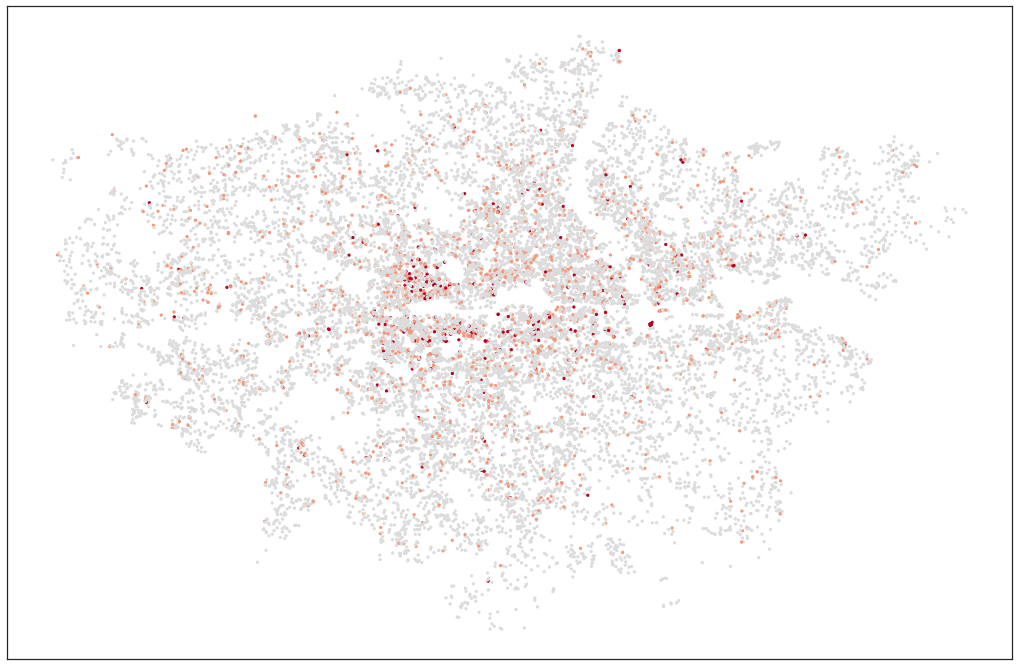

In [ ]:
sns.set_style("white")
plt.figure(figsize=(18, 12))

G = nx.subgraph(Graph_copy, results_requests.Node)
nx.draw_networkx_nodes(G, pos = dict(zip(G.nodes, [G.nodes[i]['position'] for i in G.nodes])),
                       node_color = list(nx.get_node_attributes(G,'count').values()), 
                       cmap='coolwarm', node_size=5, vmin=-1, vmax=3)
'''
nx.draw_networkx_nodes(G_hospitals, node_color = 'indigo',#list(nx.get_node_attributes(G_hospitals,'count').values()),
                       pos = dict(zip(G_hospitals.nodes, [G_hospitals.nodes[i]['position'] for i in G_hospitals.nodes])), 
                       cmap='coolwarm', node_size=600, node_shape='*')#np.array(list(nx.get_node_attributes(G_hospitals,'count').values())))

nx.draw_networkx_nodes(G_stations, node_color = 'yellow',#list(nx.get_node_attributes(G_hospitals,'count').values()),
                       pos = dict(zip(G_stations.nodes, [G_stations.nodes[i]['position'] for i in G_stations.nodes])), 
                       cmap='coolwarm', node_size=50, node_shape='D')#np.array(list(nx.get_node_attributes(G_hospitals,'count').values())))
'''
plt.show()

In [ ]:
results_stations = pd.read_csv('results3_stations.csv')

dict_osm = {x: {'name':y, 'count': z} for x, y, z in zip(results_stations.iloc[:,0], 
                                                         results_stations.Name,
                                                         results_stations.Count)}

In [ ]:
G_stations = nx.subgraph(Graph_copy, results_stations.iloc[:,0])
nx.set_node_attributes(G_stations, dict_osm)

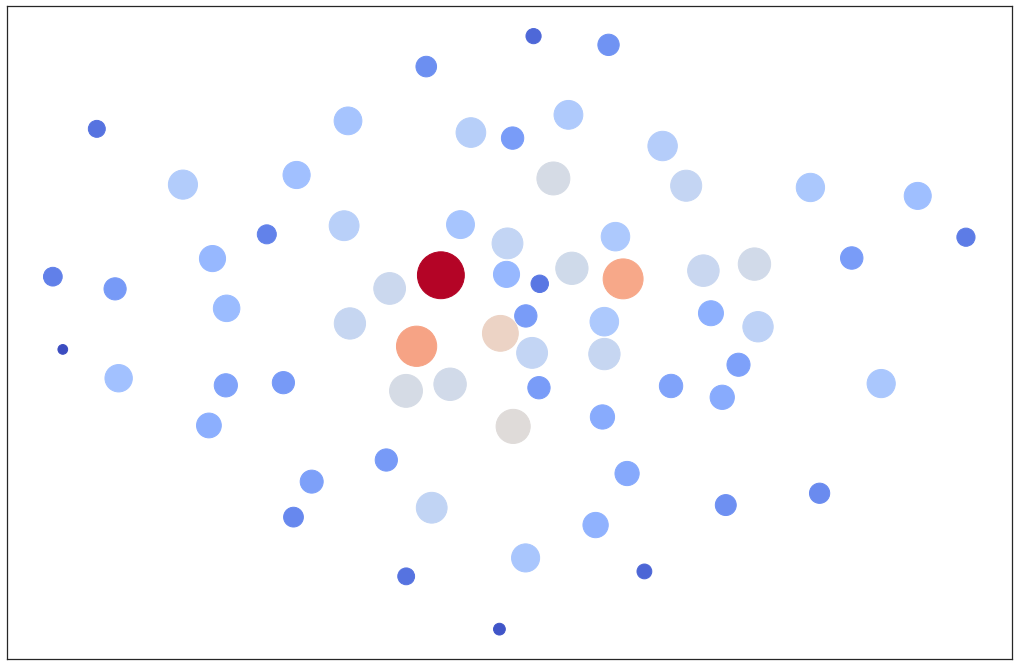

In [ ]:
sns.set_style("white")
plt.figure(figsize=(18, 12))
nx.draw_networkx_nodes(G_stations, node_color = list(nx.get_node_attributes(G_stations,'count').values()),
                       pos = dict(zip(G_stations.nodes, [G_stations.nodes[i]['position'] for i in G_stations.nodes])), 
                       cmap='coolwarm', node_size=np.array(list(nx.get_node_attributes(G_stations,'count').values())))

plt.show()

In [ ]:
#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Mean of response time:  20 minutes and 28.52 seconds 

Confidence interval:
 6 minutes and 1.54 seconds  |  34 minutes and 48.75 seconds


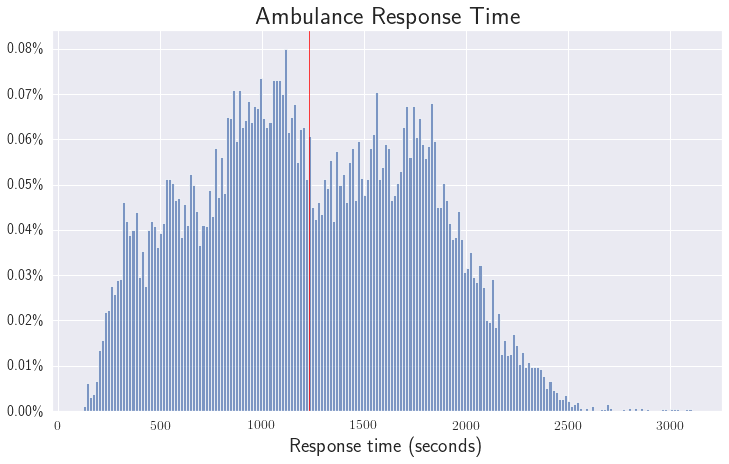

In [ ]:
from humanfriendly import format_timespan
import seaborn as sns; sns.set()
from matplotlib.ticker import PercentFormatter

#history = sim_example.region_requests()['Average response time']
history = results_requests['Average response time']


print('Mean of response time: ', format_timespan(np.mean(history)),
      '\n\nConfidence interval:\n', 
      format_timespan(np.percentile(history, 5)), ' | ',
      format_timespan(np.percentile(history, 95)))

plt.figure(figsize=(12, 7))
plt.hist(history, density=1, bins=200, alpha=.7)
#sns.kdeplot(history)
plt.axvline(np.mean(history), color='red', Linewidth=.75)
plt.title('Ambulance Response Time', fontsize=25)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=2))
plt.xlabel('Response time (seconds)', fontsize=20)
plt.show()

In [ ]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

In [ ]:
%%capture
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

## $\text{Extended Work}$

In [ ]:
results_requests

,Node,Average response time,Count
0,17109,580.956055,13
1,7942,396.958374,10
2,124581,382.758972,9
3,24740,1029.896118,9
4,108716,588.863708,8
...,...,...,...
17442,41924,1408.551270,1
17443,41925,1431.975098,1
17444,41936,1472.945923,1
17445,41938,1507.418823,1


In [ ]:
copy_final_nodes_osm = final_osm_nodes

In [ ]:
#copy_final_nodes_osm

results_requests

,Node,Average response time,Count
0,105658,66.568977,26
1,17109,238.820847,25
2,105657,65.798477,21
3,105571,81.301140,21
4,103662,174.945862,18
...,...,...,...
37475,46149,183.103928,1
37476,46148,187.554306,1
37477,46142,182.860764,1
37478,46141,182.193939,1


In [ ]:
my_dictionary = dict(zip(list(Graph_copy.nodes()), list(Graph.nodes())))

results_requests['original_node'] = [my_dictionary.get(i) for i in results_requests.Node]

In [ ]:
pd.merge(copy_final_nodes_osm, results_requests, left_on='osmid', right_on='original_node', how='inner')

In [ ]:
import requests, zipfile, io
zip_file_url = 'http://biogeo.ucdavis.edu/data/diva/adm/GBR_adm.zip'
r = requests.get(zip_file_url)
zip_file = zipfile.ZipFile(io.BytesIO(r.content))
zip_file.extractall('/content/gdrive/My Drive/Capstone/geomerty')
GBR = gpd.read_file('geomerty/GBR_adm2.shp')

london_shape = GBR[GBR.TYPE_2.isin(['London Borough','London Borough (city)','London Borough (royal)'])]
london_shape = london_shape.drop(labels=['ID_0','ISO','NAME_0','ID_1','NAME_1', 'NL_NAME_2', 'VARNAME_2'], axis=1)
london_shape = london_shape.replace('London', 'City of London')

In [ ]:
#london_shape

merged_data = pd.merge(copy_final_nodes_osm, results_requests, left_on='osmid', right_on='original_node', how='inner')
london_shape.reset_index(inplace=True)
areas = [np.nan] * len(merged_data)

for id_point, point in enumerate(merged_data.geometry):
    for idx, borough in enumerate(london_shape.geometry):
        if borough.contains(point):
            try: areas[id_point] = london_shape['NAME_2'][idx]
            except: 
                print(id_point, idx)
                break

    else:
        continue 
    break

In [ ]:
merged_data['Borough'] = areas

merged_data.Borough =  merged_data.Borough.fillna('Barnet')

merged_data.Borough.isna().sum()

0

In [ ]:
merged_data.Borough.value_counts()

Enfield                   1391
Westminster                774
Newham                     747
Southwark                  737
Brent                      726
Tower Hamlets              654
Wandsworth                 639
Lambeth                    623
Hounslow                   614
Greenwich                  607
Ealing                     594
Camden                     574
Croydon                    565
Haringey                   562
Hammersmith and Fulham     544
Hillingdon                 542
Hackney                    536
Kensington and Chelsea     512
Waltham Forest             502
Bromley                    483
Lewisham                   465
Redbridge                  464
Harrow                     463
Islington                  458
Merton                     447
Richmond upon Thames       417
Bexley                     402
Havering                   344
Barking and Dagenham       327
Sutton                     318
Kingston upon Thames       274
Barnet                     110
City of 

In [ ]:
merged_data

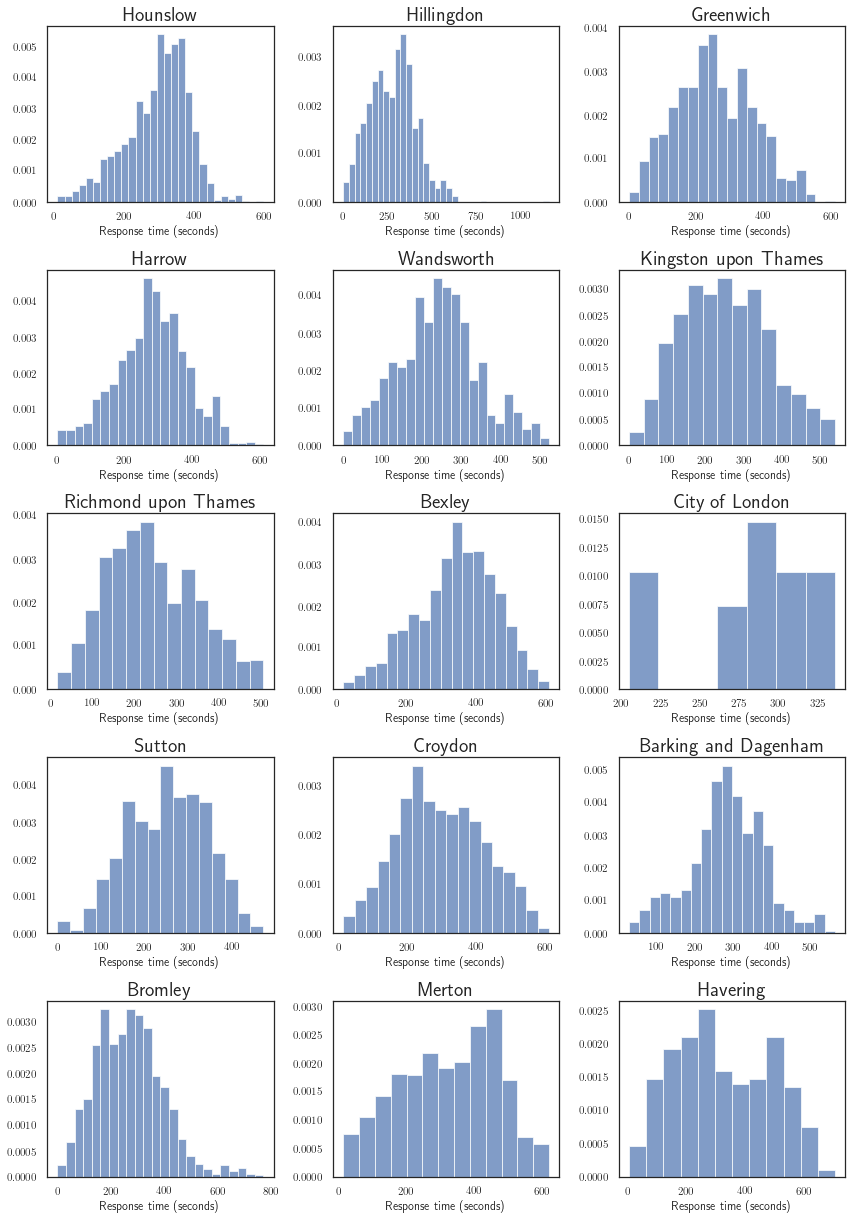

In [ ]:
plt.figure(figsize=(12, 20))

for idx,i in enumerate(merged_data.Borough.unique()[18:]):
    plt.subplot(6, 3, idx+1)
    plt.title(i, fontsize=20)
    plt.hist(merged_data[merged_data.Borough == i]['Average response time'], bins='auto', alpha=.7, density=True)
    plt.xlabel('Response time (seconds)')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(12, 20))

for idx,i in enumerate(merged_data.Borough.unique()[18:]):
    plt.subplot(6, 3, idx+1)
    plt.title(i, fontsize=20)
    plt.hist(merged_data[merged_data.Borough == i]['Average response time'], bins='auto', alpha=.7, density=True)
    plt.xlabel('Response time (seconds)')
plt.tight_layout()

In [ ]:
imd_correlation = []
for idx,i in enumerate(merged_data.Borough.unique()):
    store = merged_data[merged_data.Borough == i]['Average response time']
    imd_correlation.append([np.mean(store), np.percentile(store, 95)-np.percentile(store, 5)])

In [ ]:
merged_data

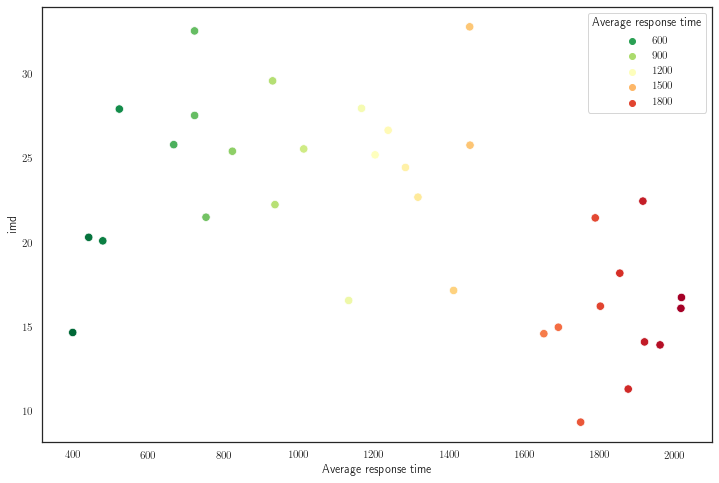

In [ ]:
'''
meas = np.array(imd_correlation)[:,0]
err = np.array(imd_correlation)[:,1]
plt.figure(figsize=(12, 6))
#plt.errorbar(merged_data.imd.unique(), meas, yerr=err, capsize=3, ecolor='red', color='black')

plt.scatter(meas, merged_data.imd.unique())

#plt.xlabel('Ambulance average speed (Km/h)', fontsize=15)
#plt.ylabel('Average response time (s)', fontsize=15)
#plt.title('Ambulance average speed vs response time', fontsize=22)
plt.show()''';
sns.set_style("white")
# This graph to check the variance is respone time in areas with different IMD estimates
plt.figure(figsize=(12, 8))
sns.scatterplot(y="imd", x="Average response time", data=merged_data.groupby('Borough').mean(), 
                hue="Average response time", legend='brief', palette='RdYlGn_r', s=70);
#plt.ylim(6, 37);

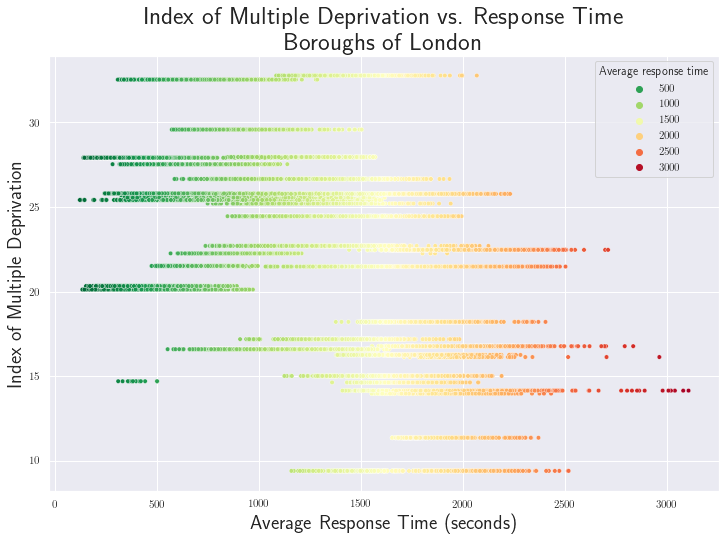

In [ ]:
sns.set_style('darkgrid')
# This graph to check the variance is respone time in areas with different IMD estimates
plt.figure(figsize=(12, 8))
sns.scatterplot(y="imd", x="Average response time", data=merged_data, 
                hue="Average response time", legend='brief', palette='RdYlGn_r', s=20);
plt.ylabel('Index of Multiple Deprivation', fontsize=20);
plt.xlabel('Average Response Time (seconds)', fontsize=20);
plt.title('Index of Multiple Deprivation vs. Response Time\nBoroughs of London', fontsize=25);
#plt.ylim(6, 37);

32.768